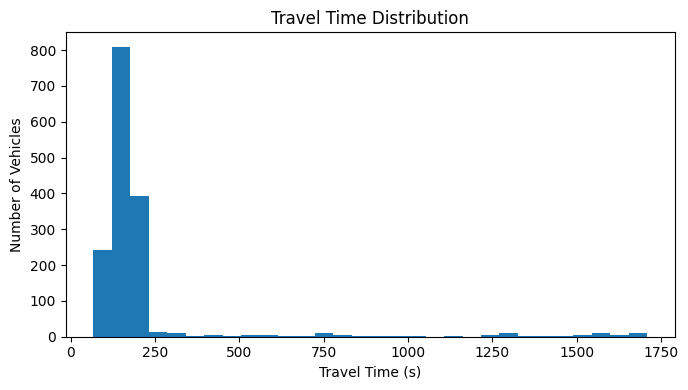

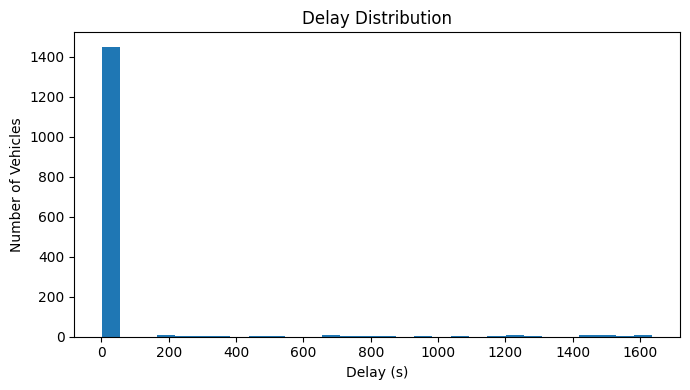

In [6]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

FILE = "tripinfo_low.xml"   # change to med/high as needed

durations = []
delays = []

tree = ET.parse(FILE)
root = tree.getroot()

for trip in root.findall("tripinfo"):
    durations.append(float(trip.get("duration")))
    delays.append(float(trip.get("timeLoss")))

# Travel time histogram
plt.figure(figsize=(7,4))
plt.hist(durations, bins=30)
plt.xlabel("Travel Time (s)")
plt.ylabel("Number of Vehicles")
plt.title("Travel Time Distribution")
plt.tight_layout()
plt.show()

# Delay histogram
plt.figure(figsize=(7,4))
plt.hist(delays, bins=30)
plt.xlabel("Delay (s)")
plt.ylabel("Number of Vehicles")
plt.title("Delay Distribution")
plt.tight_layout()
plt.show()


In [7]:
import xml.etree.ElementTree as ET

tree = ET.parse("summary_low.xml")
root = tree.getroot()

for step in root.findall("step"):
    pass  # last step contains totals

print("Mean speed:", step.get("meanSpeed"))
print("Mean travel time:", step.get("meanTravelTime"))
print("Total waiting time:", step.get("totalWaitingTime"))


Mean speed: 13.02
Mean travel time: 221.25
Total waiting time: None


Columns with non-missing values:
begin         3582
end           3582
time          3582
edge          3582
entered       3582
left          3582
arrived       3582
departed      3582
speed         2534
density       2534
flow          2534
occupancy     2534
traveltime    2531
dtype: int64


C:\Users\tasni\AppData\Local\Temp\ipykernel_35460\2027214904.py:77: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_ml.pivot_table(index="edge", columns="time", values=metric, aggfunc="mean")


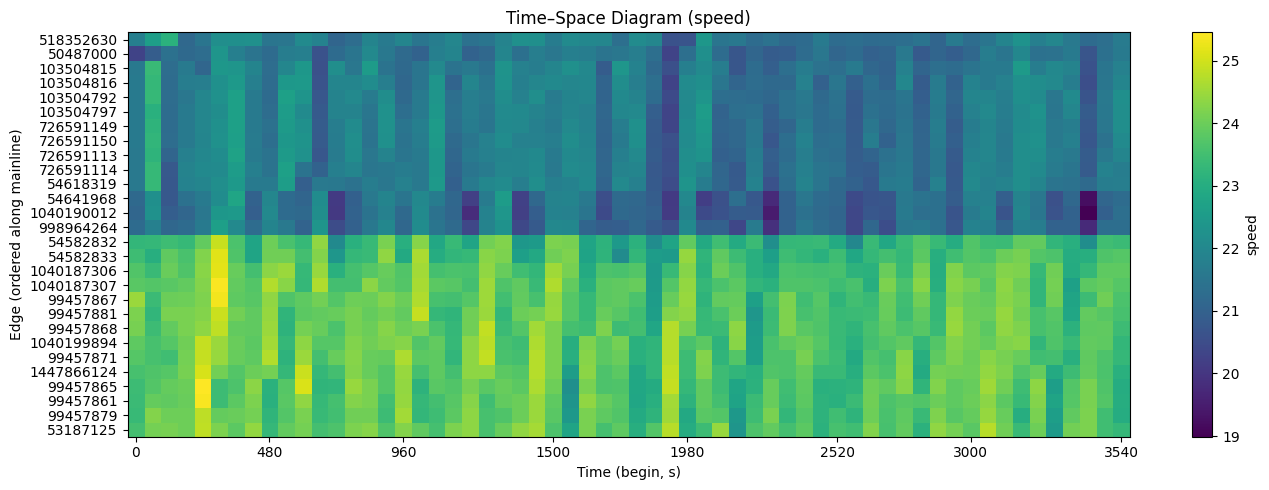

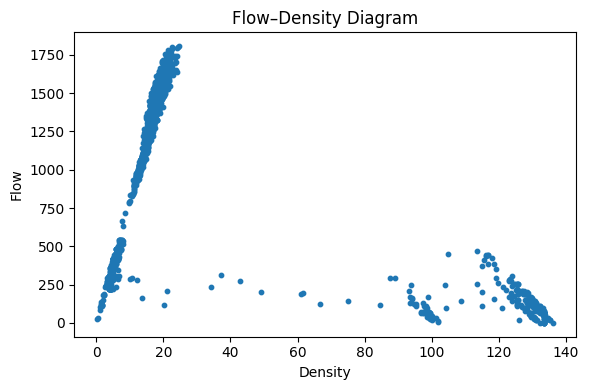

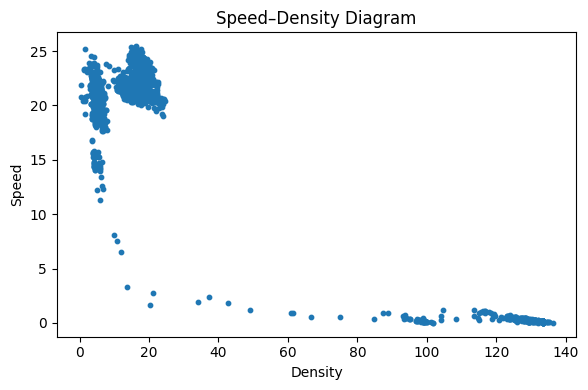

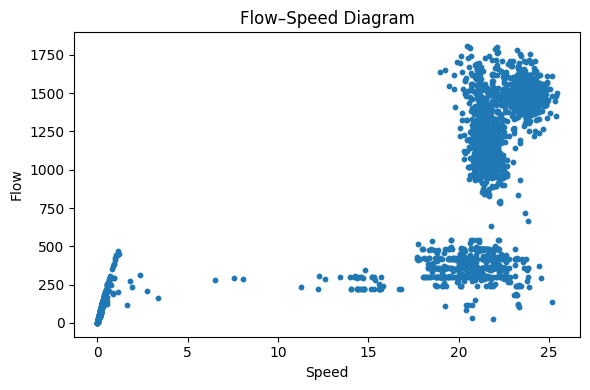

In [10]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "edgedata_low.xml"

# Put your edges in correct spatial order for the time-space plot
MAINLINE_EDGES = [
    "53187125", "99457879", "99457861", "99457865",
    "1447866124", "99457871", "1040199894", "99457868",
    "99457881", "99457867", "1040187307", "1040187306",
    "54582833", "54582832", "998964264", "1040190012",
    "54641968", "54618319", "726591114", "726591113",
    "726591150", "726591149", "103504797", "103504792",
    "103504816", "103504815", "50487000", "518352630",
]

def to_float(x):
    """Convert attribute to float; return np.nan if missing/invalid."""
    if x is None:
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

def parse_edgedata(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    rows = []

    for interval in root.findall("interval"):
        t0 = to_float(interval.get("begin"))
        t1 = to_float(interval.get("end"))

        for edge in interval.findall("edge"):
            rows.append({
                "begin": t0,
                "end": t1,
                "time": t0,  # convenient single timestamp
                "edge": edge.get("id"),

                # common edgedata attributes (may or may not exist)
                "speed": to_float(edge.get("speed")),           # m/s
                "density": to_float(edge.get("density")),       # usually veh/km (depends on config)
                "flow": to_float(edge.get("flow")),             # usually veh/h (depends on config)
                "occupancy": to_float(edge.get("occupancy")),   # %
                "traveltime": to_float(edge.get("traveltime")), # s
                "entered": to_float(edge.get("entered")),
                "left": to_float(edge.get("left")),
                "arrived": to_float(edge.get("arrived")),
                "departed": to_float(edge.get("departed")),
            })

    df = pd.DataFrame(rows)
    return df

df = parse_edgedata(FILE)

print("Columns with non-missing values:")
print(df.notna().sum().sort_values(ascending=False))

# --- TIME–SPACE DIAGRAM (choose best available metric) ---
metric_candidates = ["speed", "density", "occupancy", "traveltime", "flow"]
metric = next((m for m in metric_candidates if df[m].notna().any()), None)

if metric is None:
    raise RuntimeError("No usable metric found in edgedata_low.xml. Check the file format/output settings.")

# Filter to mainline edges only (and keep order)
df_ml = df[df["edge"].isin(MAINLINE_EDGES)].copy()
df_ml["edge"] = pd.Categorical(df_ml["edge"], categories=MAINLINE_EDGES, ordered=True)
df_ml = df_ml.sort_values(["edge", "time"])

# Pivot to a 2D matrix: edges x time
pivot = df_ml.pivot_table(index="edge", columns="time", values=metric, aggfunc="mean")

# Plot time-space heatmap
plt.figure(figsize=(14, 5))
img = plt.imshow(pivot.values, aspect="auto", origin="lower")
plt.colorbar(img, label=metric)
plt.title(f"Time–Space Diagram ({metric})")

# Make axes readable: show a few tick labels
times = pivot.columns.to_numpy()
if len(times) > 1:
    xticks = np.linspace(0, len(times)-1, num=min(8, len(times)), dtype=int)
    plt.xticks(xticks, [f"{int(times[i])}" for i in xticks])
plt.yticks(range(len(pivot.index)), pivot.index.astype(str))

plt.xlabel("Time (begin, s)")
plt.ylabel("Edge (ordered along mainline)")
plt.tight_layout()
plt.show()

# --- FUNDAMENTAL DIAGRAMS (only if columns exist) ---
# Use all edges/all times, but drop rows with missing values for each plot

def scatter_plot(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, s=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

has_flow = df["flow"].notna().any()
has_density = df["density"].notna().any()
has_speed = df["speed"].notna().any()

if has_flow and has_density:
    sub = df[["flow", "density"]].dropna()
    scatter_plot(sub["density"], sub["flow"], "Density", "Flow", "Flow–Density Diagram")
else:
    print("Skipping Flow–Density: flow or density missing in your edgedata output.")

if has_speed and has_density:
    sub = df[["speed", "density"]].dropna()
    scatter_plot(sub["density"], sub["speed"], "Density", "Speed", "Speed–Density Diagram")
else:
    print("Skipping Speed–Density: speed or density missing in your edgedata output.")

if has_flow and has_speed:
    sub = df[["flow", "speed"]].dropna()
    scatter_plot(sub["speed"], sub["flow"], "Speed", "Flow", "Flow–Speed Diagram")
else:
    print("Skipping Flow–Speed: flow or speed missing in your edgedata output.")


C:\Users\tasni\AppData\Local\Temp\ipykernel_35460\516449150.py:58: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df2.pivot_table(index="edge", columns="time", values=metric, aggfunc="mean")


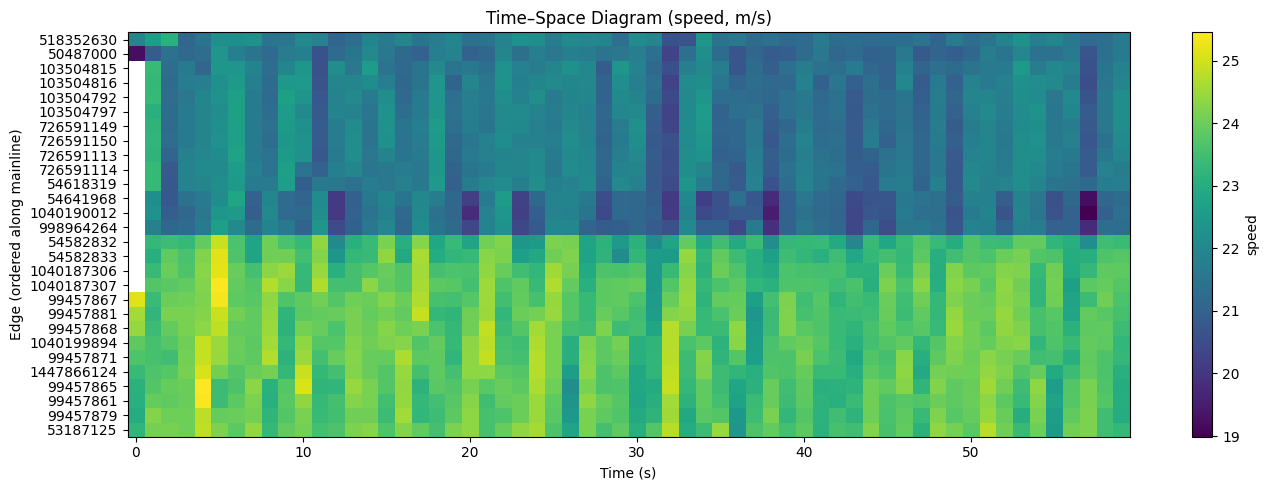

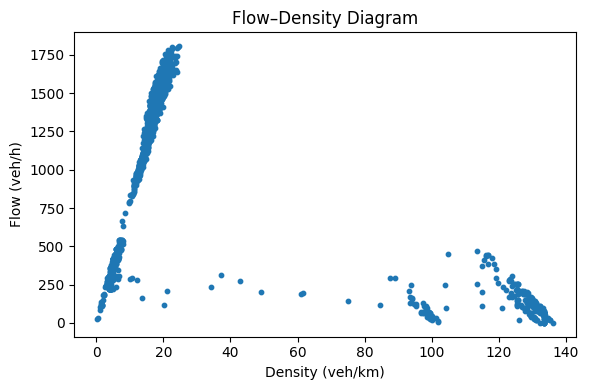

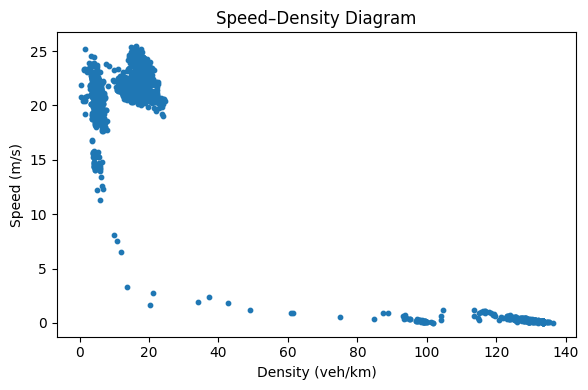

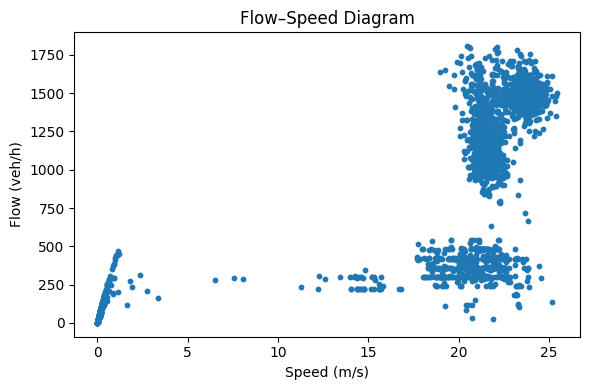

In [13]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ----------------------------
# USER INPUTS
# ----------------------------
EDGEDATA_FILE = "edgedata_low.xml"
ROUTE_FILE = "demand_low.rou.xml"   # used to get mainline order from route="stay"
MAINLINE_ROUTE_ID = "stay"          # your mainline route id


# ----------------------------
# HELPERS
# ----------------------------
def safe_float(x):
    return float(x) if x is not None else np.nan

def load_mainline_edge_order(route_file, route_id="stay"):
    tree = ET.parse(route_file)
    root = tree.getroot()
    for r in root.findall("route"):
        if r.get("id") == route_id:
            edges = r.get("edges").strip().split()
            return edges
    raise RuntimeError(f"Route id='{route_id}' not found in {route_file}")

def load_edgedata(edgedata_file):
    tree = ET.parse(edgedata_file)
    root = tree.getroot()

    rows = []
    for interval in root.findall("interval"):
        begin = safe_float(interval.get("begin"))
        end = safe_float(interval.get("end"))
        for edge in interval.findall("edge"):
            rows.append({
                "begin": begin,
                "end": end,
                "time": begin,
                "edge": edge.get("id"),
                "speed": safe_float(edge.get("speed")),        # m/s
                "flow": safe_float(edge.get("flow")),          # veh/h (when present)
                "density": safe_float(edge.get("density")),    # veh/km (when present)
                "occupancy": safe_float(edge.get("occupancy")),
                "traveltime": safe_float(edge.get("traveltime")),
                "entered": safe_float(edge.get("entered")),
                "left": safe_float(edge.get("left")),
            })
    return pd.DataFrame(rows)

def time_space_heatmap(df, edge_order, metric="speed", title=None):
    df2 = df[df["edge"].isin(edge_order)].copy()
    df2["edge"] = pd.Categorical(df2["edge"], categories=edge_order, ordered=True)

    pivot = df2.pivot_table(index="edge", columns="time", values=metric, aggfunc="mean")

    plt.figure(figsize=(14, 5))
    plt.imshow(pivot.values, aspect="auto", origin="lower")
    plt.colorbar(label=metric)
    plt.xlabel("Time (s)")
    plt.ylabel("Edge (ordered along mainline)")
    plt.title(title or f"Time–Space Diagram ({metric})")
    plt.yticks(range(len(pivot.index)), pivot.index.astype(str))
    plt.tight_layout()
    plt.show()

def scatter_fd(df, x, y, xlabel, ylabel, title):
    d = df[[x, y]].dropna()
    plt.figure(figsize=(6, 4))
    plt.scatter(d[x], d[y], s=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ----------------------------
# MAIN
# ----------------------------
if __name__ == "__main__":
    mainline_edges = load_mainline_edge_order(ROUTE_FILE, MAINLINE_ROUTE_ID)
    df = load_edgedata(EDGEDATA_FILE)

    # --- Time–space (speed) on mainline
    time_space_heatmap(
        df,
        edge_order=mainline_edges,
        metric="speed",
        title="Time–Space Diagram (speed, m/s)"
    )

    # --- Fundamental diagrams (all edges, all intervals)
    # Flow–Density
    scatter_fd(df, "density", "flow",
               xlabel="Density (veh/km)", ylabel="Flow (veh/h)",
               title="Flow–Density Diagram")

    # Speed–Density
    scatter_fd(df, "density", "speed",
               xlabel="Density (veh/km)", ylabel="Speed (m/s)",
               title="Speed–Density Diagram")

    # Flow–Speed
    scatter_fd(df, "speed", "flow",
               xlabel="Speed (m/s)", ylabel="Flow (veh/h)",
               title="Flow–Speed Diagram")


In [12]:
import xml.etree.ElementTree as ET

NET_FILE = "I94EW.net.xml"
ROUTE_FILE = "demand_low.rou.xml"

# Your key edges
MAIN_ENTRY = "53187125"
MAIN_EXIT  = "518352630"
ON_RAMP_EDGE = "727098411"
OFF_RAMP_EDGE = "726591145"

ROUTE_STAY = "stay"
ROUTE_EXIT = "exit"
ROUTE_RAMP = "ramp"


def load_net_edges(net_file):
    tree = ET.parse(net_file)
    root = tree.getroot()

    # SUMO net.xml has <edge id=...> and each has <lane id=... length=...>
    edges = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        # skip internal edges like ":..."
        if eid is None or eid.startswith(":"):
            continue

        lanes = e.findall("lane")
        if not lanes:
            continue

        # SUMO repeats lane length; take the first lane length
        length = float(lanes[0].get("length"))
        num_lanes = len(lanes)

        edges[eid] = {"length_m": length, "lanes": num_lanes}

    return edges


def load_route_edges(route_file, route_id):
    tree = ET.parse(route_file)
    root = tree.getroot()
    for r in root.findall("route"):
        if r.get("id") == route_id:
            return r.get("edges").strip().split()
    raise RuntimeError(f"Route '{route_id}' not found in {route_file}")


def route_length(edges_dict, edge_list):
    total = 0.0
    missing = []
    for eid in edge_list:
        if eid not in edges_dict:
            missing.append(eid)
        else:
            total += edges_dict[eid]["length_m"]
    return total, missing


if __name__ == "__main__":
    edges = load_net_edges(NET_FILE)

    print("\n=== Key edge info (lanes + length) ===")
    for eid in [MAIN_ENTRY, MAIN_EXIT, ON_RAMP_EDGE, OFF_RAMP_EDGE]:
        info = edges.get(eid)
        if info is None:
            print(f"{eid}: NOT FOUND in net file")
        else:
            print(f"{eid}: lanes={info['lanes']}, length={info['length_m']:.1f} m")

    print("\n=== Ramp-only and Off-ramp-only lengths (single edge) ===")
    if ON_RAMP_EDGE in edges:
        print(f"On-ramp only length ({ON_RAMP_EDGE}): {edges[ON_RAMP_EDGE]['length_m']:.1f} m")
    if OFF_RAMP_EDGE in edges:
        print(f"Off-ramp only length ({OFF_RAMP_EDGE}): {edges[OFF_RAMP_EDGE]['length_m']:.1f} m")

    print("\n=== Route lengths (sum of edges in route file) ===")
    stay_edges = load_route_edges(ROUTE_FILE, ROUTE_STAY)
    exit_edges = load_route_edges(ROUTE_FILE, ROUTE_EXIT)
    ramp_edges = load_route_edges(ROUTE_FILE, ROUTE_RAMP)

    L_stay, miss_stay = route_length(edges, stay_edges)
    L_exit,  miss_exit  = route_length(edges, exit_edges)
    L_ramp,  miss_ramp  = route_length(edges, ramp_edges)

    print(f"Mainline (stay) length:   {L_stay:.1f} m")
    print(f"Exit route length:        {L_exit:.1f} m")
    print(f"On-ramp route length:     {L_ramp:.1f} m")

    if miss_stay or miss_exit or miss_ramp:
        print("\nWARNING: Some edges were missing from net.xml parsing:")
        if miss_stay: print(" stay missing:", miss_stay)
        if miss_exit: print(" exit missing:", miss_exit)
        if miss_ramp: print(" ramp missing:", miss_ramp)



=== Key edge info (lanes + length) ===
53187125: lanes=3, length=115.5 m
518352630: lanes=3, length=528.5 m
727098411: lanes=1, length=19.6 m
726591145: lanes=1, length=61.4 m

=== Ramp-only and Off-ramp-only lengths (single edge) ===
On-ramp only length (727098411): 19.6 m
Off-ramp only length (726591145): 61.4 m

=== Route lengths (sum of edges in route file) ===
Mainline (stay) length:   3714.9 m
Exit route length:        2604.9 m
On-ramp route length:     1318.7 m


In [14]:
import xml.etree.ElementTree as ET

NET_FILE   = "I94EW.net.xml"
ROUTE_FILE = "demand_low.rou.xml"

STAY_ROUTE_ID = "stay"
EXIT_ROUTE_ID = "exit"
RAMP_ROUTE_ID = "ramp"

def load_edge_lengths(net_file):
    tree = ET.parse(net_file)
    root = tree.getroot()
    lengths = {}
    lanes = {}
    for e in root.findall("edge"):
        eid = e.get("id")
        # skip internal edges (start with ':') unless you want them
        if eid is None or eid.startswith(":"):
            continue

        lane_elems = e.findall("lane")
        if not lane_elems:
            continue

        # SUMO edge length is consistent across lanes; take first lane
        L = float(lane_elems[0].get("length"))
        lengths[eid] = L
        lanes[eid] = len(lane_elems)
    return lengths, lanes

def load_routes(route_file):
    tree = ET.parse(route_file)
    root = tree.getroot()
    routes = {}
    for r in root.findall("route"):
        rid = r.get("id")
        edges = r.get("edges")
        if rid and edges:
            routes[rid] = edges.split()
    return routes

def sum_len(edge_list, lengths):
    missing = [e for e in edge_list if e not in lengths]
    total = sum(lengths.get(e, 0.0) for e in edge_list)
    return total, missing

lengths, lane_counts = load_edge_lengths(NET_FILE)
routes = load_routes(ROUTE_FILE)

stay = routes[STAY_ROUTE_ID]
exit_r = routes[EXIT_ROUTE_ID]
ramp = routes[RAMP_ROUTE_ID]

stay_set = set(stay)

# --- Ramp-only: edges in ramp route BEFORE it hits the stay route ---
ramp_only_edges = []
merge_edge = None
for e in ramp:
    if e in stay_set:
        merge_edge = e
        break
    ramp_only_edges.append(e)

ramp_only_len, ramp_missing = sum_len(ramp_only_edges, lengths)

# --- Exit-only: edges in exit route AFTER it leaves the stay route ---
# Find the first edge in exit route that is NOT in stay route
off_start_edge = None
off_only_edges = []
left_stay = False
for e in exit_r:
    if (not left_stay) and (e not in stay_set):
        left_stay = True
        off_start_edge = e
    if left_stay:
        off_only_edges.append(e)

off_only_len, off_missing = sum_len(off_only_edges, lengths)

print("=== Merge / Diverge detection (route-based) ===")
print(f"Merge happens when ramp first reaches stay-route edge: {merge_edge}")
print(f"Off-ramp starts at first exit-route edge not in stay route: {off_start_edge}")

print("\n=== Ramp-only edges (before merge) ===")
print("count:", len(ramp_only_edges))
print("edges:", ramp_only_edges)
print(f"Ramp-only length: {ramp_only_len:.1f} m")
if ramp_missing:
    print("Missing ramp edges in net (check internal edges?):", ramp_missing)

print("\n=== Off-ramp-only edges (after diverge) ===")
print("count:", len(off_only_edges))
print("edges:", off_only_edges[:10], "..." if len(off_only_edges) > 10 else "")
print(f"Off-ramp-only length: {off_only_len:.1f} m")
if off_missing:
    print("Missing off-ramp edges in net (check internal edges?):", off_missing)

print("\n=== Key edge info you listed ===")
for eid in ["53187125", "518352630", "727098411", "726591145"]:
    print(f"{eid}: lanes={lane_counts.get(eid)}, length={lengths.get(eid)} m")


=== Merge / Diverge detection (route-based) ===
Merge happens when ramp first reaches stay-route edge: 50487000
Off-ramp starts at first exit-route edge not in stay route: 726591116

=== Ramp-only edges (before merge) ===
count: 5
edges: ['727098411', '178570538#0', '178570538#1', '727098410', '103504788']
Ramp-only length: 394.9 m

=== Off-ramp-only edges (after diverge) ===
count: 9
edges: ['726591116', '726591115', '19069383', '726591112', '726591111', '726591146', '726591144', '726591143', '726591145'] 
Off-ramp-only length: 367.2 m

=== Key edge info you listed ===
53187125: lanes=3, length=115.51 m
518352630: lanes=3, length=528.52 m
727098411: lanes=1, length=19.65 m
726591145: lanes=1, length=61.4 m



=== Scenario: low ===


C:\Users\tasni\AppData\Local\Temp\ipykernel_35460\2731280161.py:105: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df2.pivot_table(index="edge", columns="time", values=metric, aggfunc="mean")


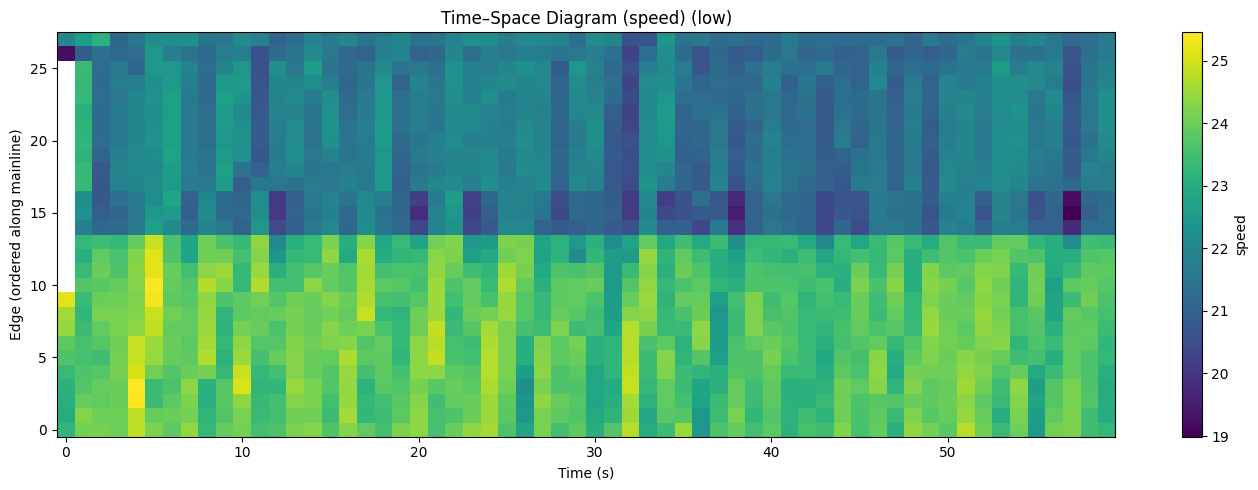

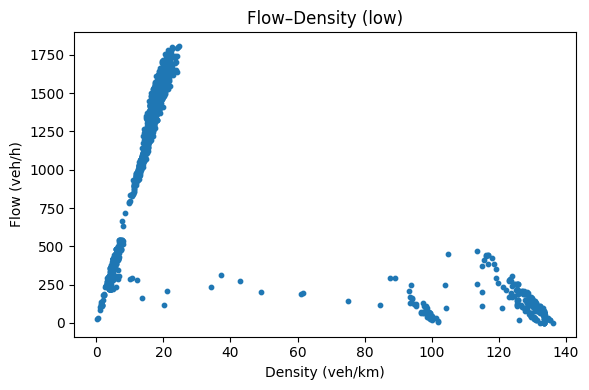

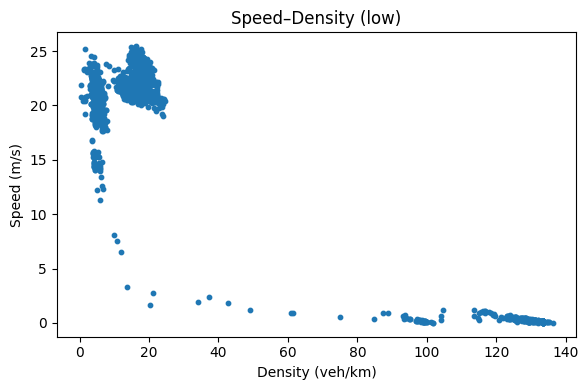

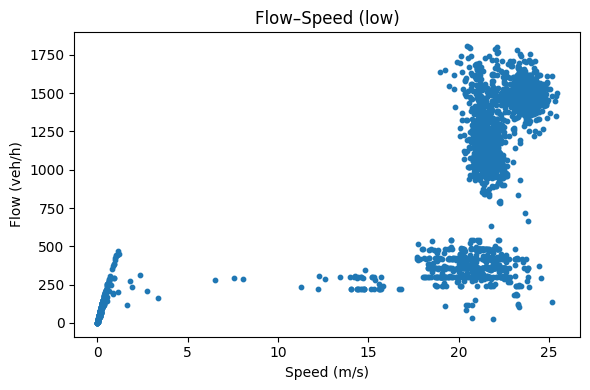

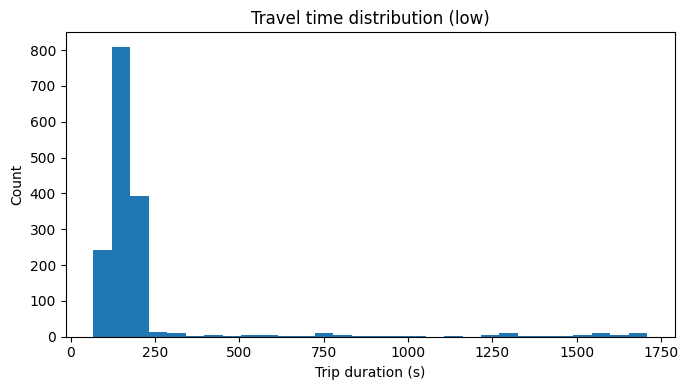

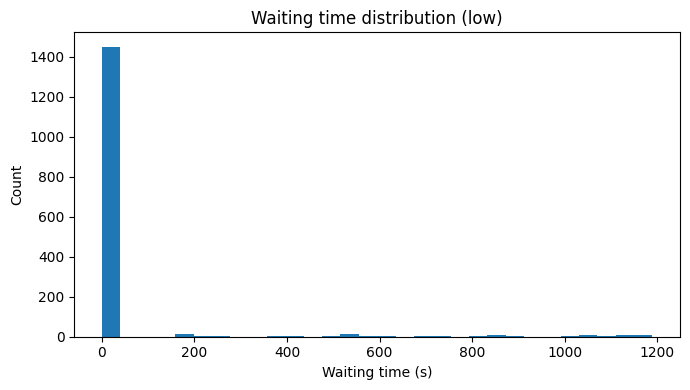

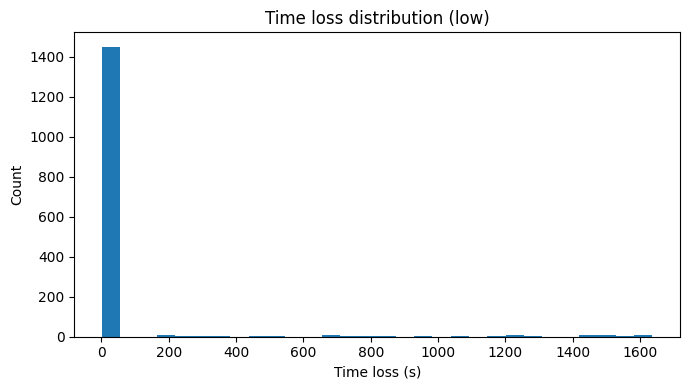

In [15]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG: set your files here
# ----------------------------
SCENARIOS = {
    "low": {
        "edgedata": "edgedata_low.xml",
        "tripinfo": "tripinfo_low.xml",
        "routefile": "demand_low.rou.xml",
        "main_route_id": "stay",   # uses your route id
    },
    # Uncomment when you have them:
    # "med": {"edgedata": "edgedata_med.xml", "tripinfo": "tripinfo_med.xml", "routefile": "demand_med.rou.xml", "main_route_id": "stay"},
    # "high":{"edgedata": "edgedata_high.xml","tripinfo": "tripinfo_high.xml","routefile": "demand_high.rou.xml","main_route_id": "stay"},
}

# Which metric for time–space heatmap
HEATMAP_METRIC = "speed"   # "speed" or "density" or "flow" or "occupancy" or "traveltime"

# ----------------------------
# Parsers
# ----------------------------
def parse_edgedata(edgedata_xml):
    """Parse SUMO edgedata output into a DataFrame with time, edge, and metrics."""
    tree = ET.parse(edgedata_xml)
    root = tree.getroot()

    rows = []
    for interval in root.findall("interval"):
        begin = float(interval.get("begin", "0"))
        end = float(interval.get("end", "0"))
        for edge in interval.findall("edge"):
            def f(attr):
                v = edge.get(attr)
                return float(v) if v is not None and v != "" else np.nan

            rows.append({
                "begin": begin,
                "end": end,
                "time": begin,
                "edge": edge.get("id"),
                "entered": f("entered"),
                "left": f("left"),
                "arrived": f("arrived"),
                "departed": f("departed"),
                "speed": f("speed"),
                "density": f("density"),
                "flow": f("flow"),
                "occupancy": f("occupancy"),
                "traveltime": f("traveltime"),
            })

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError(f"No data found in {edgedata_xml}. Check edgeData config (freq, excludeEmpty).")

    return df

def parse_tripinfo(tripinfo_xml):
    """Parse tripinfo to get travel time, waiting time, depart, arrival, etc."""
    tree = ET.parse(tripinfo_xml)
    root = tree.getroot()

    rows = []
    for trip in root.findall("tripinfo"):
        def f(attr):
            v = trip.get(attr)
            return float(v) if v is not None and v != "" else np.nan

        rows.append({
            "id": trip.get("id"),
            "depart": f("depart"),
            "arrival": f("arrival"),
            "duration": f("duration"),
            "waitingTime": f("waitingTime"),
            "timeLoss": f("timeLoss"),
            "routeLength": f("routeLength"),
            "departDelay": f("departDelay"),
        })

    return pd.DataFrame(rows)

def parse_route_edges(routefile, route_id):
    """Get ordered edges list from <route id='...'> edges='...'."""
    tree = ET.parse(routefile)
    root = tree.getroot()
    for r in root.findall("route"):
        if r.get("id") == route_id:
            return r.get("edges").split()
    raise RuntimeError(f"Route id='{route_id}' not found in {routefile}.")

# ----------------------------
# Plot helpers
# ----------------------------
def plot_time_space(df, ordered_edges, metric="speed", title_suffix=""):
    """Heatmap of metric with edges on y and time on x."""
    df2 = df[df["edge"].isin(ordered_edges)].copy()
    # keep order as categorical
    df2["edge"] = pd.Categorical(df2["edge"], categories=ordered_edges, ordered=True)

    pivot = df2.pivot_table(index="edge", columns="time", values=metric, aggfunc="mean")

    # If you want time in minutes instead of seconds:
    # pivot.columns = pivot.columns / 60.0

    plt.figure(figsize=(14, 5))
    plt.imshow(pivot, aspect="auto", origin="lower")
    plt.colorbar(label=metric)
    plt.xlabel("Time (s)")
    plt.ylabel("Edge (ordered along mainline)")
    plt.title(f"Time–Space Diagram ({metric}) {title_suffix}")
    plt.tight_layout()
    plt.show()

def plot_fundamental_diagrams(df, title_suffix=""):
    """Flow–density, speed–density, flow–speed using non-missing rows."""
    d = df.dropna(subset=["flow", "density", "speed"]).copy()
    if d.empty:
        print("No rows with flow+density+speed found (check writeAttributes / excludeEmpty).")
        return

    # Flow–Density
    plt.figure(figsize=(6, 4))
    plt.scatter(d["density"], d["flow"], s=10)
    plt.xlabel("Density (veh/km)")
    plt.ylabel("Flow (veh/h)")
    plt.title(f"Flow–Density {title_suffix}")
    plt.tight_layout()
    plt.show()

    # Speed–Density
    plt.figure(figsize=(6, 4))
    plt.scatter(d["density"], d["speed"], s=10)
    plt.xlabel("Density (veh/km)")
    plt.ylabel("Speed (m/s)")
    plt.title(f"Speed–Density {title_suffix}")
    plt.tight_layout()
    plt.show()

    # Flow–Speed
    plt.figure(figsize=(6, 4))
    plt.scatter(d["speed"], d["flow"], s=10)
    plt.xlabel("Speed (m/s)")
    plt.ylabel("Flow (veh/h)")
    plt.title(f"Flow–Speed {title_suffix}")
    plt.tight_layout()
    plt.show()

def plot_travel_time(trips_df, title_suffix=""):
    """Histogram of travel time and timeLoss/waitingTime if available."""
    if trips_df.empty:
        print("tripinfo is empty or not found.")
        return

    plt.figure(figsize=(7,4))
    plt.hist(trips_df["duration"].dropna(), bins=30)
    plt.xlabel("Trip duration (s)")
    plt.ylabel("Count")
    plt.title(f"Travel time distribution {title_suffix}")
    plt.tight_layout()
    plt.show()

    if "waitingTime" in trips_df.columns:
        plt.figure(figsize=(7,4))
        plt.hist(trips_df["waitingTime"].dropna(), bins=30)
        plt.xlabel("Waiting time (s)")
        plt.ylabel("Count")
        plt.title(f"Waiting time distribution {title_suffix}")
        plt.tight_layout()
        plt.show()

    if "timeLoss" in trips_df.columns:
        plt.figure(figsize=(7,4))
        plt.hist(trips_df["timeLoss"].dropna(), bins=30)
        plt.xlabel("Time loss (s)")
        plt.ylabel("Count")
        plt.title(f"Time loss distribution {title_suffix}")
        plt.tight_layout()
        plt.show()

# ----------------------------
# MAIN
# ----------------------------
def main():
    for name, cfg in SCENARIOS.items():
        print(f"\n=== Scenario: {name} ===")

        df_edge = parse_edgedata(cfg["edgedata"])
        main_edges = parse_route_edges(cfg["routefile"], cfg["main_route_id"])

        # Plot time–space on mainline
        plot_time_space(df_edge, main_edges, metric=HEATMAP_METRIC, title_suffix=f"({name})")

        # Fundamental diagrams (all edges)
        plot_fundamental_diagrams(df_edge, title_suffix=f"({name})")

        # Tripinfo plots (if file exists)
        try:
            trips = parse_tripinfo(cfg["tripinfo"])
            plot_travel_time(trips, title_suffix=f"({name})")
        except FileNotFoundError:
            print("tripinfo file not found, skipping travel time plots.")

if __name__ == "__main__":
    main()


Total non-internal network length: 5.706 km (3.545 mi)
I-94 (ref=I 94) length:            3.715 km (2.308 mi)
